In [1]:
%pylab inline
import cosmology as cosmo
import prepare as pre
from scipy import spatial
import sys
import healpy as hp
#import mpi4py.MPI as MPI
nside = 512
nside_ldp = 4096

Populating the interactive namespace from numpy and matplotlib


In [2]:
pwd

'/mnt/ddnfs/data_users/fydong/8100/cal_halo/produce-cmb'

In [4]:
class dL_z():
    def __init__(self,om0,ol0,ww):
        self.nz = 10000
        self.nbox  = 3
        self.zmin  = 0.
        self.zmax  = 10.
        self.zstep = (self.zmax-self.zmin)/self.nz
        self.zbin  = self.zstep*np.arange(self.nz)+self.zmin
        self.dC    = np.zeros(self.nz)
        for i in np.arange(self.nz):
            self.dC[i] = cosmo.d_comoving_w(self.zbin[i],ol0,om0,ww)
        self.coef_dz  = np.polyfit(self.dC,   self.zbin, 10)
        self.coef_zd  = np.polyfit(self.zbin, self.dC,   10)

class DENSITY():
    def __init__(self,om0,ol0):
        self.om0    = om0
        self.ol0    = ol0
        self.boxize = pre.boxize/1.
        self.boxhalf= pre.boxize/2.
        self.nx     = 512
        self.nsnap  = 8
        self.cM     = 300000. # km/s
        self.H0     = 100 #100h km/s /Mpc,h=0.1
        _zsnap      = np.loadtxt(pre.simu+'_snapz.dat')
        self.snap   = np.int32(_zsnap[:,0])
        self.zsnap  = _zsnap[:,1]
        self.zstart,self.zend = 0.01,0.6#0.01,0.6
        self.rstart = cosmo.d_comoving(self.zstart,self.ol0,self.om0)
        self.rend   = cosmo.d_comoving(self.zend,self.ol0,self.om0)
    def load_halo(self,dirh,i):
        xh          = np.load(dirh+'current_mlimit-3_simu'+pre.simu+'_Nsnap'+np.str(i)+'.npy')
        xh[:,:3]    = xh[:,:3]/1e3
        #period condition
        for i in np.arange(3):
            _id1,_id2   = (xh[:,i]<0),(xh[:,i]>self.boxize)
            xh[_id1,i] = xh[_id1,i]+self.boxize
            xh[_id2,i] = xh[_id2,i]-self.boxize
        return xh
    def abundance(self,iz):
        _coef   = np.loadtxt('abundance/simu'+pre.simu+'-'+self.zobs[iz]+'-'+self.zobs[iz+1]+'Mh_Mag.dat')
        _mlimit = np.polyval(_coef,Mag)
        index_m = (np.log10(self.xh[:,-1])+10>_mlimit)
        sys.stdout.write('abundance,_mlimit=%lg,nsub=%d\n'%(_mlimit,np.count_nonzero(index_m)))
        sys.stdout.flush()
        return self.xh[index_m]
    def gen_halo(self,Mag,flag_load):
        self.fname_base = 'BASSz'+np.str(self.zstart)+'-'+np.str(self.zend)+'Mag'+np.str(Mag)
        self.zobs   = ['0.01','0.2','0.4','0.6']
        if(flag_load==0):
            for i in np.arange(self.nsnap-1)+1:
                _z1     = self.zsnap[i]
                _z2     = self.zsnap[i-1]
                _zm     = 0.5*(_z1+_z2)
                _iz     = np.min((np.int32(np.floor(_zm/0.2)),2)) #ensure z<0.6
                if(flag_load==0):
                    self.xh  = self.load_halo(dirh,self.snap[i])
                    print('snapshot=%d,z1=%lg,z2=%lg,zm=%lg,iz=%d,%d'%(self.snap[i],_z1,_z2,_zm,_iz,(np.int32(np.floor(_zm/0.2)))))
                    self.xh  = self.abundance(_iz)
                    if(i==1):  self.halo = self.xh[:,:3].copy()
                    _d1      = cosmo.d_comoving(_z1,self.ol0,self.om0)
                    _d2      = cosmo.d_comoving(_z2,self.ol0,self.om0)
                    _tmp     = self.rotate(_d1,_d2,self.xh[:,:3])
                    if(i==1): self.halo = _tmp.copy()
                    else:     self.halo = np.append(self.halo,_tmp,0)
            ##index = (self.halo[:,2]>self.rstart)*(self.halo[:,2]<self.rend)
            self.halo = self.halo
            np.save(dirh+self.fname_base+'.npy',self.halo)
        if(flag_load==1):
            self.halo = np.load(dirh+self.fname_base+'.npy')

    def rotate(self,d1,d2,pos):
        n11  = np.int32(d1/self.boxize)
        n21  = np.int32(d2/self.boxize)
        sys.stdout.write("n11=%d,n21=%d,d1=%lg,d2=%lg\n"%(n11,n21,d1,d2))
        sys.stdout.flush()
        if((n11==0) and (n21==0)): _pos = pre.pos_xyz(pos,0,d1,d2,2)
        if((n11==1) and (n21==1)):  _pos = pre.pos_xyz(pos,self.boxize,d1,d2,1)
        if((n11==2) and (n21==2)): _pos = pre.pos_xyz(pos,2*self.boxize,d1,d2,0)
        if((n11==0  and  n21==1) or (n11==1 and n21==2) or (n11==2 and n21==3)):
            _pos = pre.pos_xyz_rotate_slice(pos,n11,n21,d1,d2,self.boxize)
        return _pos

    def gen_edge_halo(self):
        self.dmax       = self.rend#self.boxize*3.
        self.ran        = np.zeros((3,2))
        r2 = np.sqrt(self.boxhalf**2.+self.dmax**2.)
        r3 = np.sqrt(r2**2.+self.boxhalf**2.)
        self.ran[0,1]   = np.arcsin(self.boxhalf/r3) #theta
        self.ran[1,1]   = np.arcsin(self.boxhalf/r2) #phi
        self.ran[0,0],self.ran[1,0] = -self.ran[0,1],-self.ran[1,1]
        self.ran[2,0],self.ran[2,1] = self.zstart,self.zend
    def gen_radec_halo(self,Mag,flag_radec): #err in the early version
        self.gen_edge_halo()
        if(flag_radec==0):
            dlz = dL_z(self.om0,self.ol0,-1.)
            self.radec = np.zeros((self.halo.shape[0],4))
            for i in np.arange(2):
                self.halo[:,i] = self.halo[:,i]-self.boxhalf
            _r2 = np.sqrt(self.halo[:,1]**2.+self.halo[:,2]**2.)
            self.radec[:,2] = np.sqrt(_r2**2.+self.halo[:,0]**2.)
            self.radec[:,0] = np.arcsin(self.halo[:,0]/self.radec[:,2]) #dec
            self.radec[:,1] = np.arcsin(self.halo[:,1]/_r2)             #ra
            self.radec[:,3] = np.polyval(dlz.coef_dz,self.radec[:,2])
            index = (self.radec[:,0]>self.ran[0,0])*(self.radec[:,0]<self.ran[0,1])*(self.radec[:,1]>self.ran[1,0])*(self.radec[:,1]<self.ran[1,1])*(self.radec[:,3]>self.ran[2,0])*(self.radec[:,3]<self.ran[2,1])
            np.save(dirh+self.fname_base+'radec.npy',self.radec[index])
        self.radec = np.load(dirh+self.fname_base+'radec.npy')

    def gen_ldp(self,Mag,radius,flag_ldp):
        rr = radius/60.*np.pi/180
        self.nside_ldp = nside_ldp
        self.npix_ldp  = hp.nside2npix(self.nside_ldp)
        self.pix_ldp   = np.arange(self.npix_ldp)
        if(flag_ldp==0):
           thetal,phil = hp.pix2ang(self.nside_ldp,self.pix_ldp,nest=True) #90-dec,ra
           ra_h,dec_h  = phil-pre.dra,np.pi/2-thetal #(ra here is not the standard ra)
           index       = np.where((ra_h>self.ran[1,0]) & (ra_h<self.ran[1,1]) & (dec_h>self.ran[0,0]) & (dec_h<self.ran[0,1]))
           self.radecl = np.zeros((self.npix_ldp,2))
           self.radecl[:,0],self.radecl[:,1]= np.pi/2-thetal,phil-pre.dra #non-standard dec,ra-ldp
           self.index = index
           self.theta,self.phi = np.pi/2-self.radec[:,0],pre.dra+self.radec[:,1] #gal
           mask_ldp = np.ones(self.npix_ldp)
           vec_g  = hp.ang2vec(self.theta,self.phi) #galaxy
           for i in np.arange(self.theta.shape[0]):
               idx_search = hp.query_disc(self.nside_ldp,vec_g[i],rr,nest=True)
               mask_ldp[idx_search] = 0
           mask_edge = np.zeros(self.npix_ldp)
           mask_edge[index] = 1
           mask_ldp[mask_edge==0] = 0
           self.radecl = self.radecl[mask_ldp==1]
           np.save(dirh+self.fname_base+'rr'+np.str(radius)+'radec-ldp-healpix.npy',self.radecl)
        self.radecl = np.load(dirh+self.fname_base+'rr'+np.str(radius)+'radec-ldp-healpix.npy')
    def rr(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])*(x1[0]-x2[0])+(x1[1]-x2[1])*(x1[1]-x2[1]))
    def gen_mask_edge(self,Nside): #change!
        _Npix       = hp.nside2npix(Nside)
        _Pix        = np.arange(_Npix)
        _theta,_phi = hp.pix2ang(Nside,_Pix,nest=True) #90-dec,ra
        _ra_h,_dec_h = _phi-pre.dra,np.pi/2-_theta #(ra here is not the standard ra)
        _index      = np.where( (_ra_h>self.ran[1,0]) & (_ra_h<self.ran[1,1]) & (_dec_h>self.ran[0,0]) & (_dec_h<self.ran[0,1]) )
        _Map        = np.zeros(_Npix)
        _Map[_index]= 1
        self.the_e,self.phi_e = _theta[_index],_phi[_index]
        return _Map
    def obs_Mask(self): #bright star Mask    #change!
        self.nside_Mask = 512
        self.Mask = np.load('obs/bassmask'+np.str(self.nside_Mask)+'.npy')
    def center_theta_phi(self,tmap,the,phi,a_the,a_phi): #change!
        _index  = hp.ang2pix(self.nside, the+a_the,phi+a_phi,nest=True)
        _rmap   = np.zeros(self.npix)
        _index_ori = hp.ang2pix(self.nside,the,phi,nest=True)
        _rmap[_index_ori] = tmap[_index]
        return _rmap
    def gen_den_map_Mask(self,ra,dec,a_the,a_phi,flag_l): #change!
        self.nside= nside
        self.npix = hp.nside2npix(self.nside)
        self.pix   = np.arange(self.npix)
        _theta,_phi = np.pi/2-dec,ra+pre.dra
        self.o_map     = pre.heapy_map(_theta,_phi,self.nside,True)
        self.mask_edge      = self.gen_mask_edge(self.nside)
        self.obs_Mask() #load bright star Mask
        self.sMask             = self.center_theta_phi(self.Mask,self.the_e,self.phi_e,a_the,a_phi) #random choose Mask from observation
        self.index_edge      = (self.mask_edge==1) #add Mask
        self.g_mean   = np.mean(self.o_map[self.index_edge])
        ##self.o_map     = self.o_map/self.g_mean-1
        self.index_Mask     = ((self.mask_edge==1))#*(self.sMask==1))  #add Mask
        self.g_map     = -np.ones(self.npix)
        self.g_map[self.index_Mask]     = self.o_map[self.index_Mask]
        _theta,_phi  = hp.pix2ang(self.nside,self.pix,nest=True)
        self.theta_map,self.phi_map  = _theta[self.index_Mask],_phi[self.index_Mask]
        if(flag_l==1): fname = self.fname_base+'rr'+np.str(radius)+'radec-ldp'
        if(flag_l==0): fname = self.fname_base+'rr'+np.str(radius)+'radec-gal'
        np.save(dirh+fname+'-den-Mask-healpix.npy',np.vstack((self.theta_map,self.phi_map,self.g_map[self.index_Mask]))) #y,x

In [4]:
print(np.count_nonzero(density.mask_edge==1),np.count_nonzero(density.o_map!=-1))
print(np.count_nonzero(density.index_Mask==1),np.count_nonzero(density.g_map!=-1))

NameError: name 'density' is not defined

In [5]:
Mag       = -22
radius    = 7#arcmin
om0,ol0   = 0.268,0.732
dirh      = '/home/fydong/work/8100/cal_halo/data/subhalo_pos/'
density   = DENSITY(om0,ol0)

# load subhalos and do abudance matching
flag_load = 0
# gain ra,dec for subhalos
flag_radec= 0
# generate the LDPs
flag_ldp  =  0

density.gen_halo(Mag,flag_load)
density.gen_radec_halo(Mag,flag_radec)
# gain density map for LDPs/subhalos
flag_den_ldp = 1
if(flag_den_ldp==1):
    density.gen_ldp(Mag,radius,flag_ldp)
#a_the,a_phi = np.pi*(0.),np.pi*1.6
#a_the,a_phi = np.pi*(-0.05),np.pi*1.3
#a_the,a_phi = np.pi*(-0.05),np.pi*0.7
#a_the,a_phi = np.pi*(-0.06),np.pi*0.5 
a_the,a_phi = np.pi*(-0.),-np.pi*0.5
density.gen_den_map_Mask(density.radecl[:,1],density.radecl[:,0],a_the,a_phi,flag_den_ldp)

snapshot=13,z1=0.625111,z2=0.761583,zm=0.693347,iz=2,3
abundance,_mlimit=13.3046,nsub=19827
n11=2,n21=3,d1=1621.37,d2=1908.56
snapshot=14,z1=0.500822,z2=0.625111,zm=0.562966,iz=2,2
abundance,_mlimit=13.3046,nsub=22001
n11=2,n21=2,d1=1339.89,d2=1621.37
snapshot=15,z1=0.381529,z2=0.500822,zm=0.441175,iz=2,2
abundance,_mlimit=13.3046,nsub=24132
n11=1,n21=2,d1=1050.94,d2=1339.89
snapshot=16,z1=0.274441,z2=0.381529,zm=0.327985,iz=1,1
abundance,_mlimit=13.1943,nsub=36660
n11=1,n21=1,d1=775.416,d2=1050.94
snapshot=17,z1=0.175902,z2=0.274441,zm=0.225171,iz=1,1
abundance,_mlimit=13.1943,nsub=39251
n11=0,n21=1,d1=508.316,d2=775.416
snapshot=18,z1=0.0856633,z2=0.175902,zm=0.130783,iz=0,0
abundance,_mlimit=13.1333,nsub=49521
n11=0,n21=0,d1=252.472,d2=508.316
snapshot=19,z1=0,z2=0.0856633,zm=0.0428316,iz=0,0
abundance,_mlimit=13.1333,nsub=52131
n11=0,n21=0,d1=0,d2=252.472


In [16]:
density.snap

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], dtype=int32)

In [357]:
print(density.the_e.max(),density.the_e.min())
print(density.phi_e.max(),density.phi_e.min())

(1.9133967256508617, 1.2281959279389314)
(1.935883754311679, 1.2057088992781138)


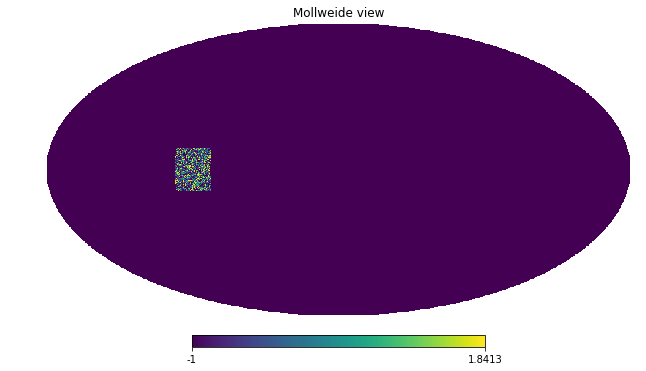

In [11]:
hp.mollview(density.g_map,nest=True)

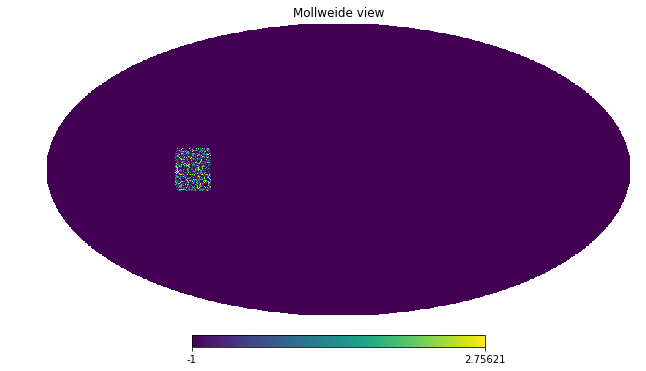

In [18]:
hp.mollview(density.o_map,nest=True)

(array([33667.,  4101.,  3858.,  5965.,  2626.,  2366.,  2186.,  4072.,
         1982.,  1864.,  3480.,  1592.,  1544.,  1418.,  3093.,  1492.,
         1349.,  2594.,  1218.,  1181.,  1200.,  2408.,  1064.,  1071.,
          962.,  1939.,  1003.,  1075.,  1901.,   903.,   834.,   860.,
         1688.,   833.,   728.,  1524.,   715.,   678.,   651.,  1364.,
          674.,   712.,  1247.,   593.,   505.,   728.,  1304.,   661.,
          550.,  4045.]),
 array([-1.        , -0.92761988, -0.85523976, -0.78285964, -0.71047952,
        -0.6380994 , -0.56571929, -0.49333917, -0.42095905, -0.34857893,
        -0.27619881, -0.20381869, -0.13143857, -0.05905845,  0.01332167,
         0.08570179,  0.1580819 ,  0.23046202,  0.30284214,  0.37522226,
         0.44760238,  0.5199825 ,  0.59236262,  0.66474274,  0.73712286,
         0.80950298,  0.8818831 ,  0.95426321,  1.02664333,  1.09902345,
         1.17140357,  1.24378369,  1.31616381,  1.38854393,  1.46092405,
         1.53330417,  1.6056842

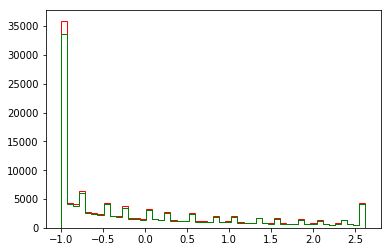

In [343]:
plt.hist(density.o_map[density.index_edge],bins=50,color='r',histtype='step')
plt.hist(density.g_map[density.index_Mask],bins=50,color='g',histtype='step')

In [289]:
print(np.count_nonzero(density.o_map[density.index_edge]==-1))

29108


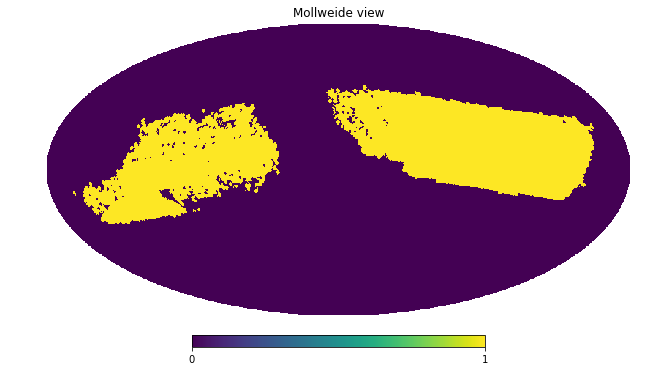

In [362]:
a_the,a_phi = np.pi*(-0.5),-np.pi*0.3
hp.mollview(density.Mask,rot=(a_the*180/np.pi,a_phi*0.15*180/np.pi,0),nest=True)

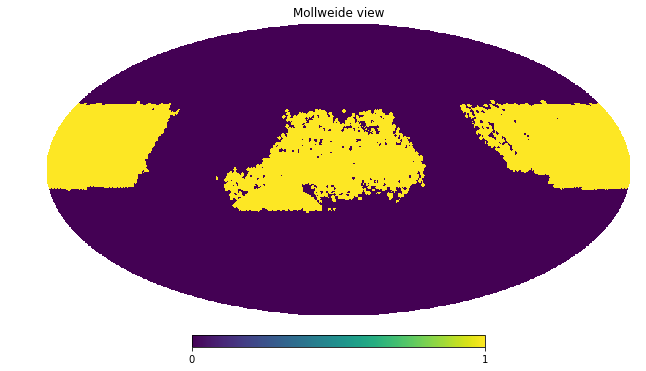

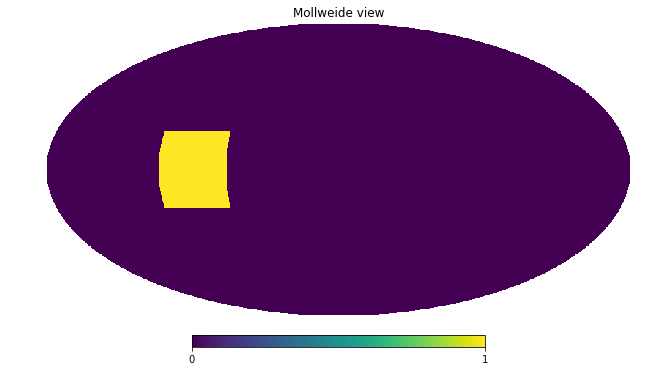

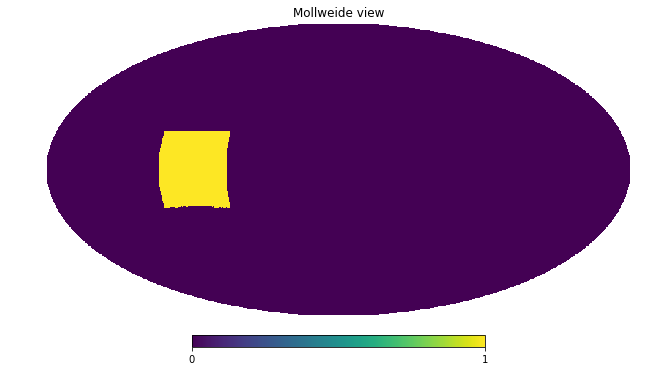

In [331]:
#Mask = np.load('obs/bassmask1024.npy')
hp.mollview(Mask,nest=True)
hp.mollview(density.mask_edge,nest=True)
hp.mollview(density.sMask,nest=True)